# Evaluate CNN trained on WEAVE-Pristine synthetic spectra

This notebook evaluates the saved CNN model by plotting the following diagnostics

In [1]:
# Cell 1: Setup paths and imports
%matplotlib inline
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
from scipy import stats

# Paths (adjust if needed)
PROJECT_ROOT = Path('..').resolve()          # notebook lives in results/
sys.path.insert(0, str(PROJECT_ROOT))

# Define paths to the output of the evaluation script
RESULTS_DIR = PROJECT_ROOT / 'results' / 'test_output'
PREDICTIONS_PATH = RESULTS_DIR / 'test_predictions.npz'
HISTORY_PATH = PROJECT_ROOT / 'ML_models' / 'output' / 'cnn_model_offline.history.npz'

print('Predictions file:', PREDICTIONS_PATH)
print('History file:', HISTORY_PATH)

# Check if predictions exist
if not PREDICTIONS_PATH.exists():
    print("⚠️ Predictions file not found. Please run the evaluation script first:")
    print(f"python evaluate_model.py --input ../data/processed_spectra_10k.h5 --model-path ../ML_models/output/cnn_model_offline.pth --indices ../ML_models/output/cnn_model_offline_test_indices.npy --output-dir {RESULTS_DIR}")
else:
    print("✅ Predictions file found.")

Predictions file: /lustre06/project/6016730/minjihk/WEAVE_Pristine/results/test_output/test_predictions.npz
History file: /lustre06/project/6016730/minjihk/WEAVE_Pristine/ML_models/output/cnn_model_offline.history.npz
✅ Predictions file found.


Loaded keys: ['train_loss', 'val_loss', 'grad_norm_mean', 'grad_norm_max', 'grad_norm_min', 'train_loss_eval_mode']


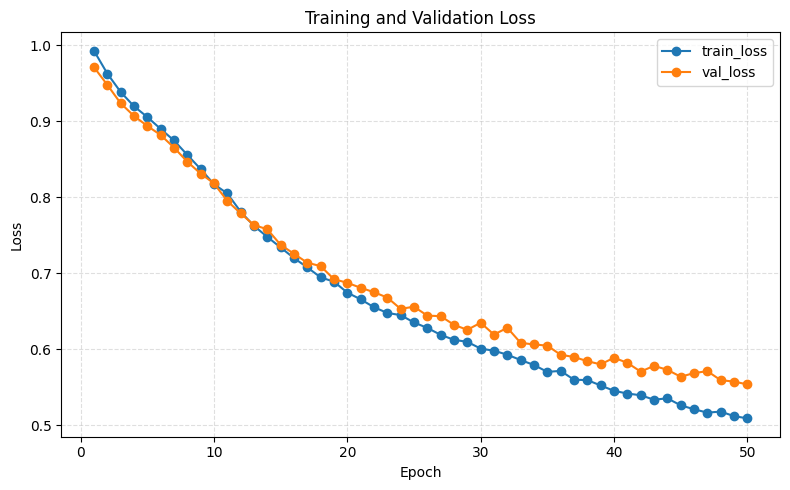

In [2]:
# Cell 2: Plot loss curves (train vs validation)

# Path to the .npz history file - edit this if needed
HISTORY_PATH = Path('../ML_models/output/cnn_model_offline.history.npz')

def plot_loss_curves(history_path):
    if not history_path.exists():
        raise FileNotFoundError(f'History file not found: {history_path}')

    data = np.load(history_path, allow_pickle=True)
    print('Loaded keys:', list(data.keys()))

    train_loss = data['train_loss']
    val_loss = data['val_loss']

    fig, ax = plt.subplots(figsize=(8, 5))
    epochs = np.arange(1, len(train_loss) + 1)
    ax.plot(epochs, train_loss, marker='o', label='train_loss')
    ax.plot(epochs, val_loss, marker='o', label='val_loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_loss_curves(HISTORY_PATH)

In [3]:
# Cell 3: Load Predictions
if PREDICTIONS_PATH.exists():
    data = np.load(PREDICTIONS_PATH, allow_pickle=True)
    print("Loaded keys:", list(data.keys()))
    
    indices = data['indices']
    preds_phys = data['preds_phys']
    targets_phys = data['targets_phys']
    target_cols = data['target_cols']
    
    print(f"Loaded {len(indices)} samples")
    print(f"Target columns: {target_cols}")
    
    # Expose to globals for compatibility with plotting functions
    globals()['test_preds'] = preds_phys
    globals()['test_truths'] = targets_phys
    globals()['indices'] = indices
    
    # Calculate residuals
    residuals_phys = preds_phys - targets_phys
    globals()['test_residuals'] = residuals_phys
    
    # Create dynamic mapping for plotting
    # We want to map 'teff', 'logg', 'feh', 'micro', 'geometry' to their actual indices
    label_key_to_idx = {}
    
    i = 0
    for col in target_cols:
        label_key_to_idx[col] = i
        i += 1
    
    # Update the global variable expected by the plotting function
    globals()['label_key_to_idx'] = label_key_to_idx

else:
    print("Skipping load (file missing)")

Loaded keys: ['indices', 'preds_normalized', 'targets_normalized', 'preds_phys', 'targets_phys', 'target_cols']
Loaded 793 samples
Target columns: ['Al' 'Ba' 'C' 'Ca' 'Co' 'Cr' 'Cu' 'Eu' 'FeH' 'Li' 'Mg' 'Mn' 'N' 'Na' 'Nd'
 'Ni' 'O' 'Sc' 'Si' 'Sr' 'Teff' 'Ti' 'V' 'Y' 'Zn' 'geometry' 'logg' 'vmic']


In [4]:
# Binned residual-violin plotting utility (ready to run)
# Default parameter names & mapping from short keys to column indices
param_names_default = ['Teff (K)', 'logg', '[Fe/H]', 'microturbulence', 'geometry']

def plot_resid_violin_binned(label_keys=None,
                             preds=None,
                             truths=None,
                             n_bins=10,
                             bin_method='quantile',   # 'quantile' or 'linear'
                             min_count=5,
                             y_lims=None,
                             savename=None,
                             figsize_per_row=2.7,
                             show_hist=True):
    """
    Make binned violin plots of residuals (pred - truth) for each requested label.
    - label_keys: list like ['teff','logg','feh','micro'] or None to use all defaults
    - preds, truths: numpy arrays shape (N, n_params). If None, uses globals 'preds' and 'truths'.
    - n_bins: number of bins along the target domain (if domain has <= n_bins unique values, uses those unique values)
    - bin_method: 'quantile' (equal-count bins) or 'linear' (equal-width bins)
    - min_count: minimum samples in a bin to include it in the plot
    - y_lims: list/tuple of per-parameter +/- y-limits (optional). If None, computed automatically per parameter
    - savename: optional path to save the figure
    - show_hist: whether to show the background distribution of truth values
    """
    # grab preds/truths from globals if not provided
    preds = preds if preds is not None else globals().get('test_preds', None)
    truths = truths if truths is not None else globals().get('test_truths', None)
    if preds is None or truths is None:
        raise RuntimeError("preds and truths not found: pass them or run evaluation cell first.")

    preds = np.asarray(preds)
    truths = np.asarray(truths)
    if preds.shape != truths.shape:
        raise RuntimeError(f"preds and truths must have same shape, got {preds.shape} vs {truths.shape}")

    n_params = preds.shape[1]
    if label_keys is None:
        # default order: teff, logg, feh, micro (truncate to available params)
        label_keys = ['Teff','logg','FeH','vmic','geometry'][:n_params]

    # prepare figure
    n_plots = len(label_keys)
    fig, axes = plt.subplots(n_plots, 1, figsize=(12, n_plots * figsize_per_row), squeeze=False)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=1)

    for i, key in enumerate(label_keys):
        ax = axes[i,0]
        # Use the global mapping
        idx = globals()['label_key_to_idx'].get(key, None)
        
        if idx is None:
            print(f"Warning: Key '{key}' not found in mapping. Skipping.")
            continue
            
        if idx >= n_params:
            raise KeyError(f"Index {idx} for key '{key}' is out of range (n_params={n_params})")

        pretty_name = key
        if key == 'Teff':
            pretty_name = 'T$_{\\mathrm{eff}}$ [K]'
        elif key == 'FeH':
            pretty_name = '[Fe/H]'
        elif key == 'logg':
            pretty_name = '$\\log{g}$'
        elif key == 'vmic':
            pretty_name = 'microturbulence (km/s)'
        elif key == 'geometry':
            pretty_name = 'Geometry'

        tgt_vals = truths[:, idx]
        diff = preds[:, idx] - truths[:, idx]

        # --- Background Histogram ---
        if show_hist:
            ax_hist = ax.twinx()
            ax_hist.hist(tgt_vals, bins=50, color='gray', alpha=0.4, zorder=0)
            ax_hist.set_ylabel('Counts', color='gray', alpha=0.5, fontsize=8)
            ax_hist.tick_params(axis='y', labelcolor='gray', labelsize=7)
            # Ensure violin plots are on top
            ax.set_zorder(ax_hist.get_zorder() + 1)
            ax.patch.set_visible(False) # make ax transparent so ax_hist shows through

        # Choose bin edges
        unique_vals = np.unique(tgt_vals)
        if unique_vals.size <= n_bins:
            # use exact unique values as "bins"
            bin_centers = unique_vals
            box_data = []
            box_positions = []
            for val in bin_centers:
                sel = np.where(tgt_vals == val)[0]
                if len(sel) >= min_count:
                    box_positions.append(val)
                    box_data.append(diff[sel])
            if len(box_positions) == 0:
                ax.text(0.5, 0.5, 'No bins with >= min_count samples', ha='center', va='center')
                continue
            box_positions = np.array(box_positions)
            box_width = np.mean(np.diff(np.sort(box_positions))) / 2 if box_positions.size>1 else 0.5
        else:
            # regular binning
            if bin_method == 'quantile':
                quantiles = np.linspace(0, 1, n_bins + 1)
                edges = np.unique(np.quantile(tgt_vals, quantiles))
                # if edges collapsed because of duplicates, fallback to linear
                if len(edges) <= 2:
                    edges = np.linspace(tgt_vals.min(), tgt_vals.max(), n_bins + 1)
            else:
                edges = np.linspace(tgt_vals.min(), tgt_vals.max(), n_bins + 1)

            box_positions = []
            box_data = []
            for j in range(len(edges)-1):
                low, high = edges[j], edges[j+1]
                if j == len(edges)-2:
                    # include rightmost edge
                    sel = np.where((tgt_vals >= low) & (tgt_vals <= high))[0]
                else:
                    sel = np.where((tgt_vals >= low) & (tgt_vals < high))[0]
                if len(sel) >= min_count:
                    center = (low + high) / 2.0
                    box_positions.append(center)
                    box_data.append(diff[sel])
            box_positions = np.array(box_positions)
            if box_positions.size == 0:
                ax.text(0.5, 0.5, 'No bins with >= min_count samples', ha='center', va='center')
                continue
            # choose a sensible width
            if box_positions.size > 1:
                spacing = np.mean(np.diff(np.sort(box_positions)))
                box_width = spacing * 0.9
            else:
                # single bin
                span = (edges[-1] - edges[0]) if edges is not None else 1.0
                box_width = span * 0.2

        # Plot violins
        parts = ax.violinplot(box_data, positions=box_positions, widths=box_width,
                              showextrema=True, showmeans=False)
        for pc in parts['bodies']:
            pc.set_facecolor('#4C9F70')
            pc.set_edgecolor('black')
            pc.set_alpha(0.7)
        if 'cmedians' in parts:
            parts['cmedians'].set_color('black')

        # Annotate median and standard deviation of residuals (global for that parameter)
        med = np.median(diff)
        std_ = np.std(diff)
        if 'eff' in pretty_name:
            ann = '$\\widetilde{m}$=%0.0f  $s$=%0.0f' % (med, std_)
        elif 'rad' in pretty_name:
            ann = '$\\widetilde{m}$=%0.1f  $s$=%0.1f' % (med, std_)
        else:
            ann = '$\\widetilde{m}$=%0.2f  $s$=%0.2f' % (med, std_)
        ax.annotate(ann, (0.75, 0.8), size=8, xycoords='axes fraction', bbox=bbox_props)

        # Axes labels, grid, zero line
        ax.set_xlabel(f'{pretty_name}')
        ax.set_ylabel(r'$\Delta$ %s' % pretty_name)
        ax.axhline(0, linewidth=1.5, c='black', linestyle='--')

        # y-limits
        if y_lims is not None:
            # if y_lims provided as list per param, pick ith or scalar
            if isinstance(y_lims, (list, tuple, np.ndarray)):
                if len(y_lims) >= len(label_keys):
                    yl = y_lims[i]
                else:
                    yl = y_lims[0]
            else:
                yl = y_lims
            ax.set_ylim(-yl, yl)
        else:
            # auto compute: a few times the median absolute deviation / percentile
            rng = np.percentile(np.abs(diff), 98)
            yl = max(rng * 1.2, np.std(diff) * 3, 1e-8)
            ax.set_ylim(-yl, yl)

        # x-limits & ticks
        ax.set_xlim(np.min(box_positions) - box_width*2, np.max(box_positions) + box_width*2)
        ax.tick_params(labelsize=8)
        ax.grid(True, linestyle='--', alpha=0.3)

        # Annotate sample size of each bin on top as ticklabels
        ax.text(box_positions[0] - 2*box_width, 1.05 * ax.get_ylim()[1], 'n = ', fontsize=8)
        ax_t = ax.secondary_xaxis('top')
        ax_t.set_xticks(box_positions)
        ax_t.set_xticklabels([len(d) for d in box_data])
        ax_t.tick_params(axis='x', direction='in', labelsize=8)

        # If Teff, set integer ticks
        if key == 'Teff':
            tick_positions = ax.get_xticks()
            ax.set_xticklabels([int(x) for x in tick_positions])

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)

    if savename is not None:
        path = Path(savename)
        fig.savefig(path, facecolor='white', transparent=False, dpi=150, bbox_inches='tight', pad_inches=0.05)
        print(f"Saved figure to {path}")

    plt.show()

/tmp/ipykernel_1954279/926718664.py:196: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(x) for x in tick_positions])


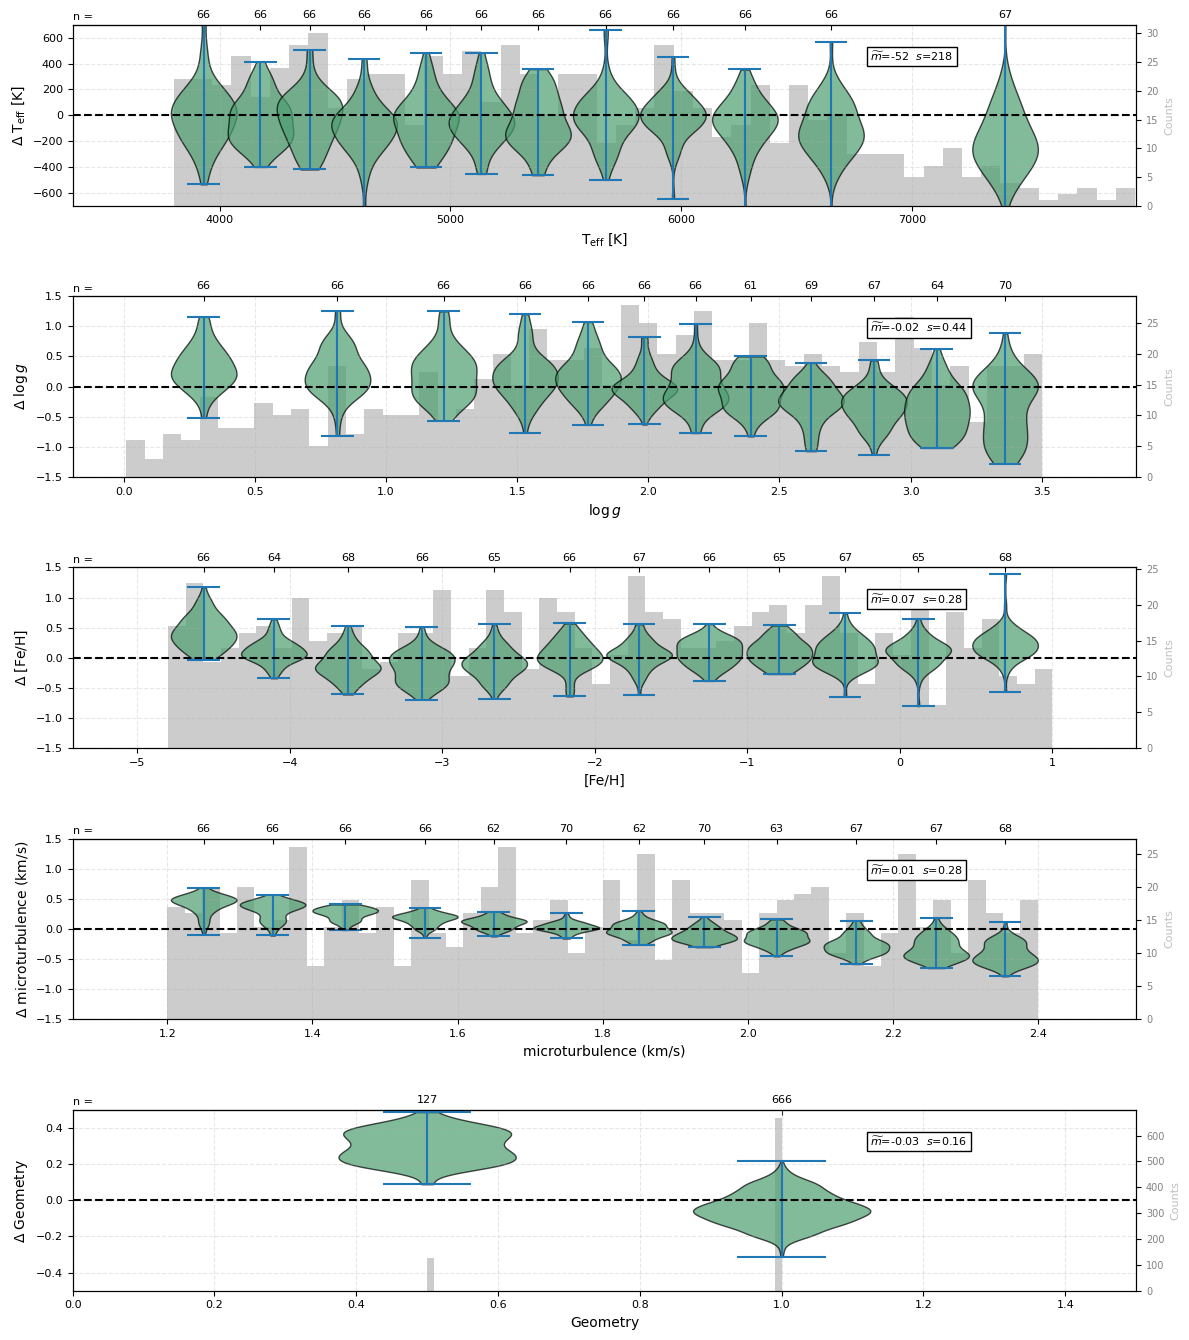

In [5]:
# Plot primary parameters + geometry
plot_resid_violin_binned(
        label_keys=['Teff', 'logg', 'FeH', 'vmic', 'geometry'],
        preds=globals()['test_preds'],
        truths=globals()['test_truths'],
        n_bins=12,
        bin_method='quantile',
        min_count=1,
        y_lims=[700, 1.5, 1.5, 1.5, 0.5] # Added y_lim for geometry
)

Plotting abundances: ['Al', 'Ba', 'C', 'Ca', 'Co']


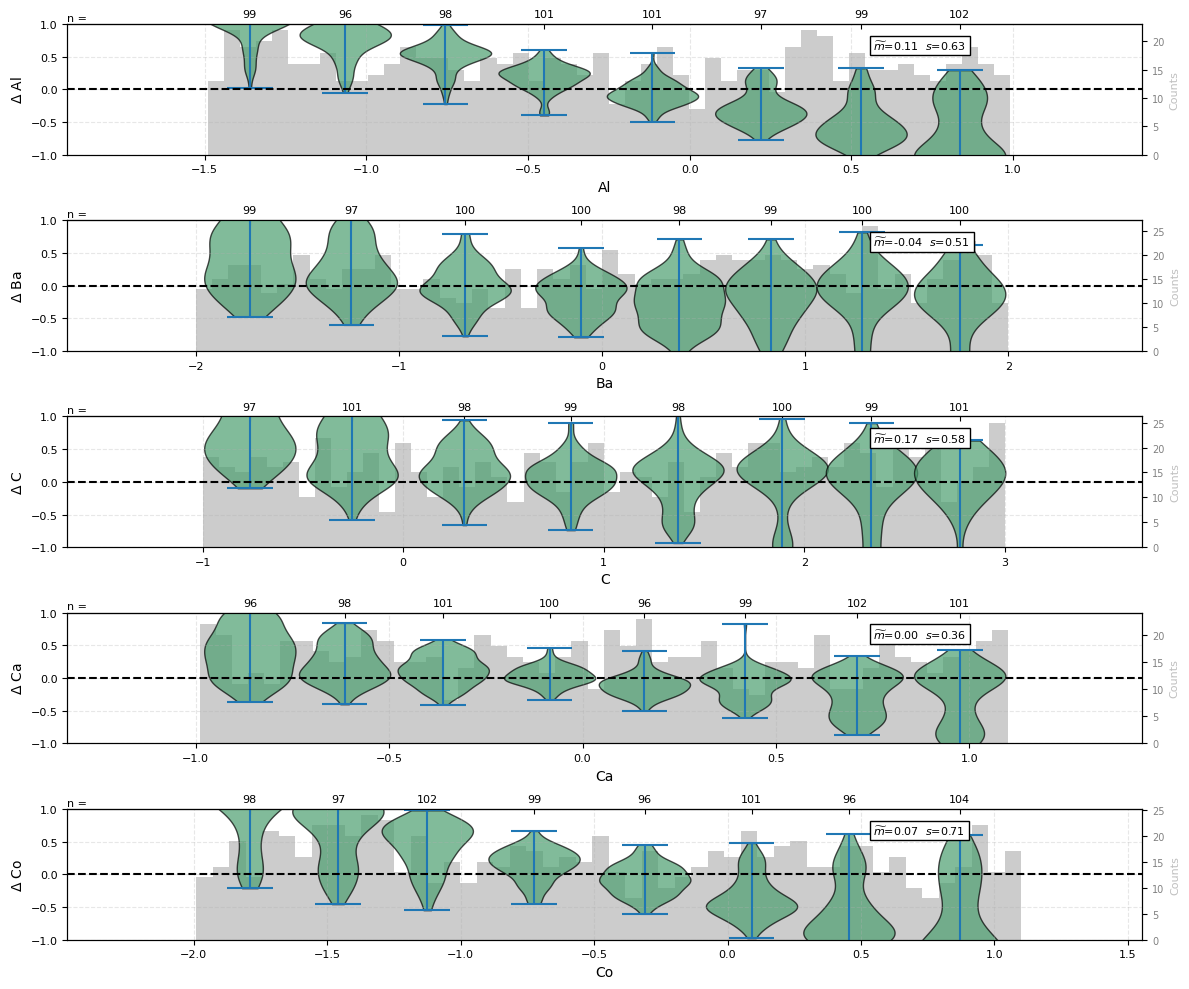

Plotting abundances: ['Cr', 'Cu', 'Eu', 'Li', 'Mg']


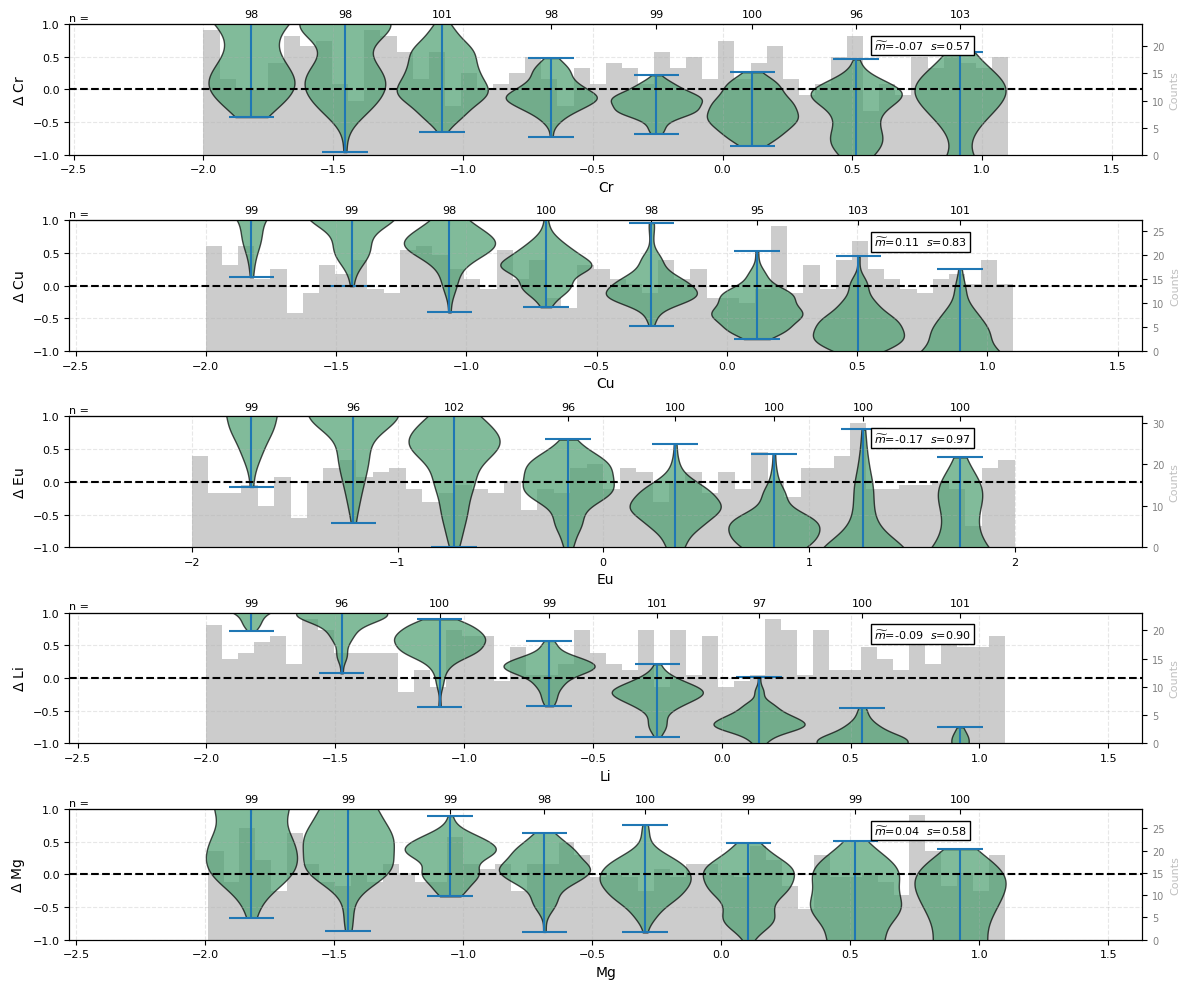

Plotting abundances: ['Mn', 'N', 'Na', 'Nd', 'Ni']


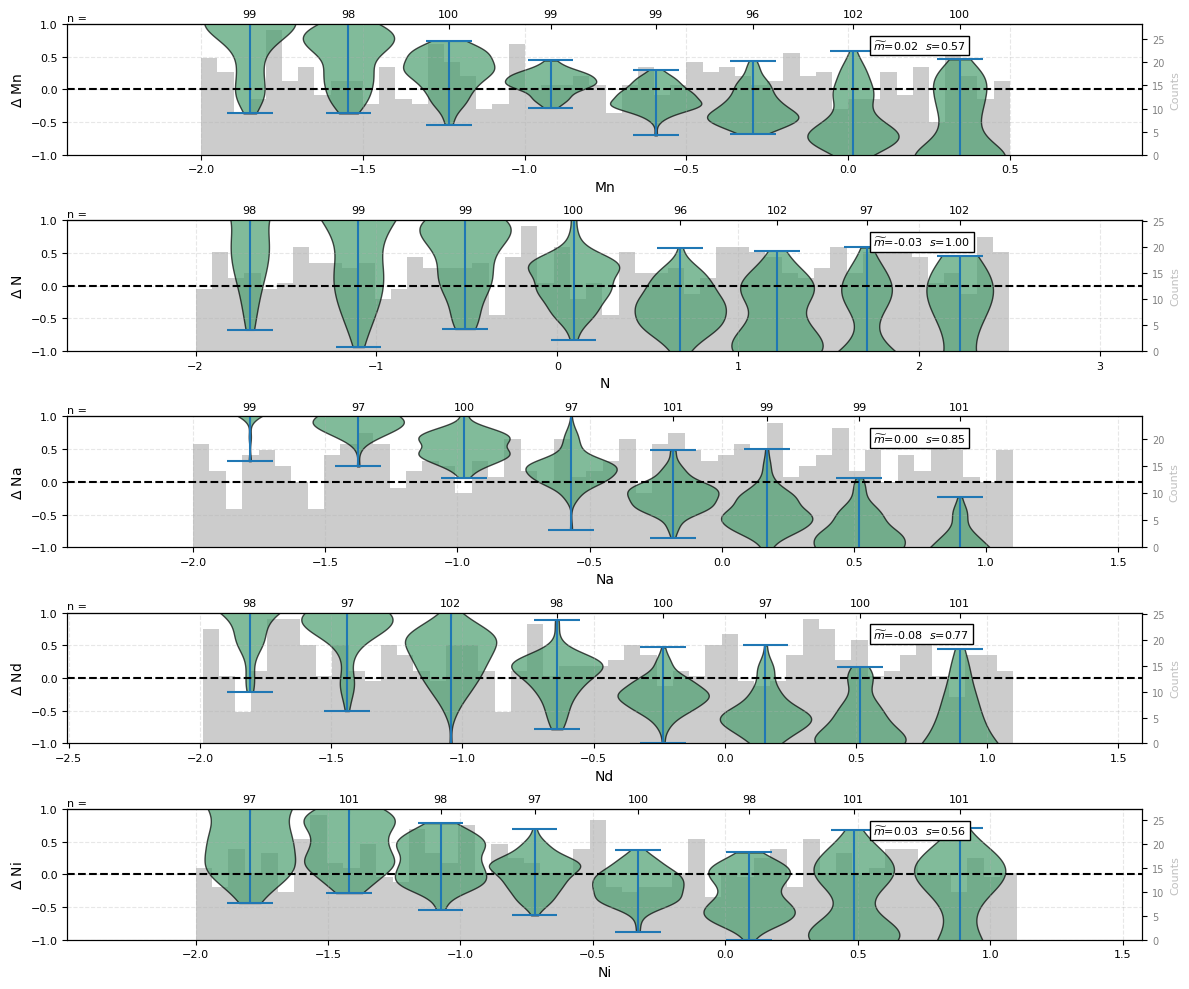

Plotting abundances: ['O', 'Sc', 'Si', 'Sr', 'Ti']


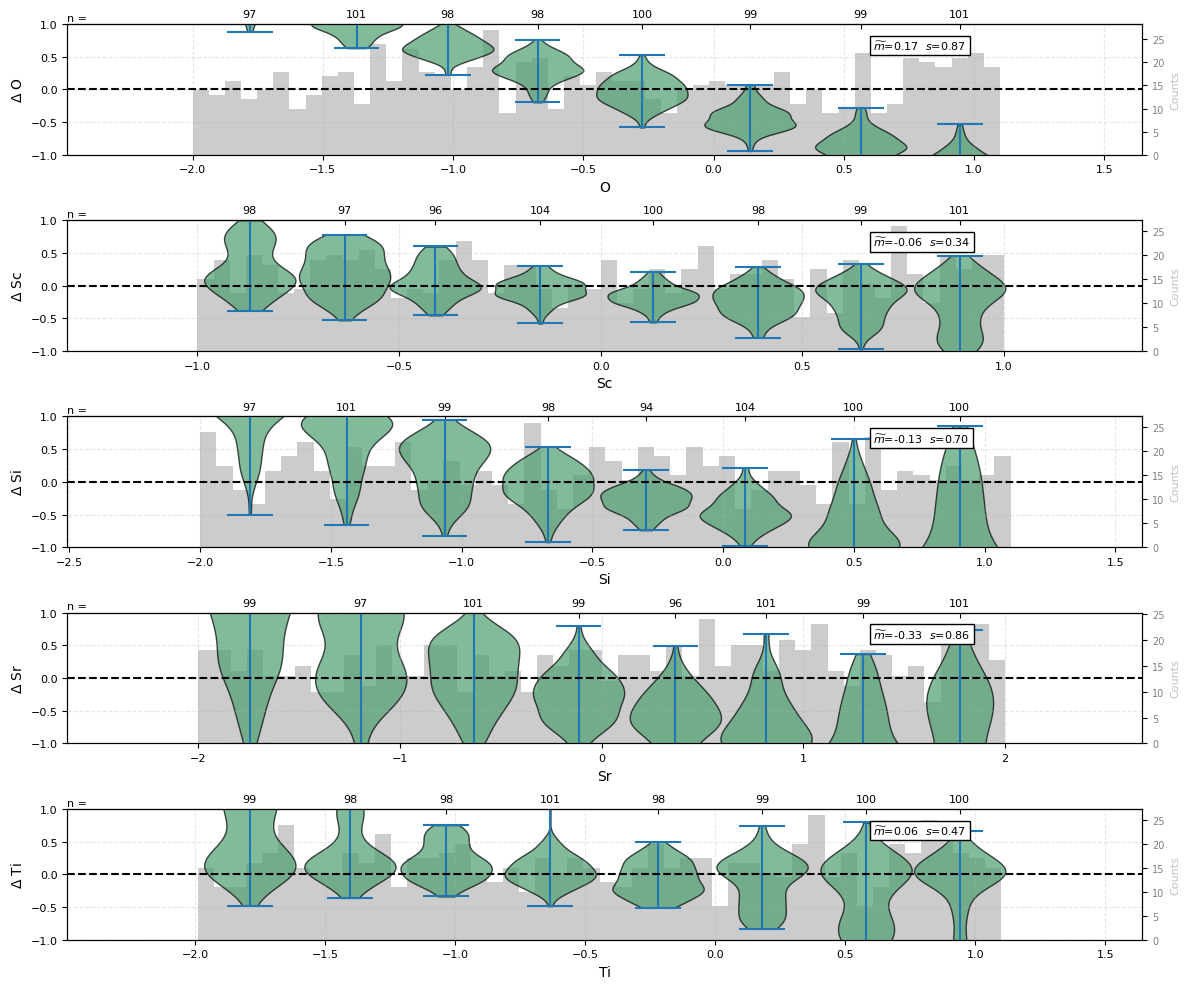

Plotting abundances: ['V', 'Y', 'Zn']


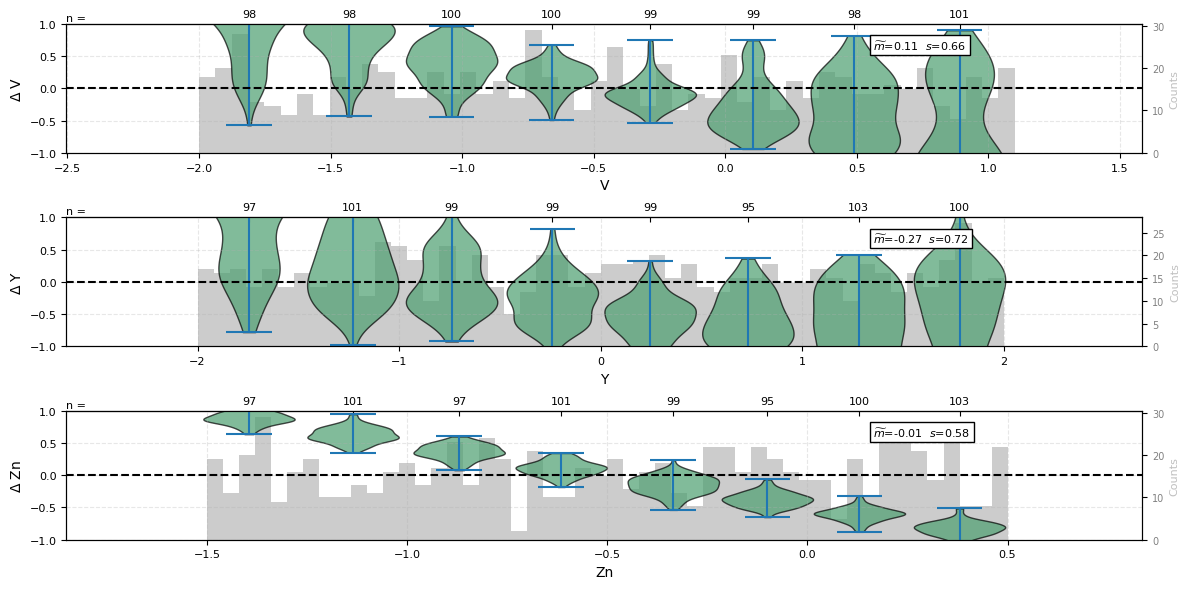

In [6]:
# Cell: Abundance Violin Plots
if 'test_preds' in globals():
    # Find all abundance columns (starting with A( or containing [)
    abundance_keys = ['Al', 'Ba', 'C', 'Ca', 'Co', 'Cr', 'Cu', 'Eu', 'Li', 'Mg', 
                      'Mn', 'N', 'Na', 'Nd', 'Ni', 'O', 'Sc', 'Si', 'Sr', 'Ti', 'V', 'Y', 'Zn']
    
    if abundance_keys:
        # Plot in groups of 5 to avoid massive figures
        for i in range(0, len(abundance_keys), 5):
            subset = abundance_keys[i:i+5]
            print(f"Plotting abundances: {subset}")
            plot_resid_violin_binned(
                label_keys=subset,
                preds=globals()['test_preds'],
                truths=globals()['test_truths'],
                n_bins=8,
                bin_method='quantile',
                min_count=1,
                y_lims=1, # Abundances usually have smaller ranges
                figsize_per_row=2.0
            )
else:
    print("Predictions not loaded.")

### Metrics table

In [7]:
# Cell: Global Performance Metrics Table
def calculate_global_metrics(preds, truths, param_names=None):
    """
    Calculate global performance metrics for stellar parameter predictions.
    
    Parameters:
    -----------
    preds : np.ndarray
        Predicted values, shape (n_samples, n_parameters)
    truths : np.ndarray  
        True values, shape (n_samples, n_parameters)
    param_names : list, optional
        Names of parameters. If None, uses default stellar parameter names.
    
    Returns:
    --------
    pd.DataFrame
        Metrics table with parameters as rows and metrics as columns
    """
    if param_names is None:
        param_names = ['T_eff (K)', 'log(g)', '[Fe/H]', 'microturbulence (km/s)']
    
    # Ensure we only use available parameters
    n_params = min(preds.shape[1], len(param_names))
    param_names = param_names[:n_params]
    
    metrics_data = []
    
    for i, param_name in enumerate(param_names):
        # Calculate residuals for this parameter
        residuals = preds[:, i] - truths[:, i]
        
        # Calculate metrics
        rmse = np.sqrt(np.mean(residuals**2))  # Root Mean Squared Error
        mae = np.mean(np.abs(residuals))       # Mean Absolute Error  
        std = np.std(residuals)                # Standard deviation of residuals
        mad = stats.median_abs_deviation(residuals, scale='normal')  # Median Absolute Deviation
        
        # Additional useful metrics
        bias = np.mean(residuals)              # Mean bias (systematic offset)
        r2 = 1 - np.var(residuals) / np.var(truths[:, i])  # R-squared
        
        metrics_data.append({
            'Parameter': param_name,
            'RMSE': rmse,
            'MAE': mae, 
            'STD': std,
            'MAD': mad,
            'Bias': bias,
            'R²': r2
        })
    
    return pd.DataFrame(metrics_data)

In [8]:
# Check if predictions exist in globals from previous inference cell
preds = globals().get('test_preds')      # Physical units predictions
truths = globals().get('test_truths')    # Physical units true values
target_cols = globals().get('target_cols', None)

if preds is not None and truths is not None:
    # Calculate metrics table
    metrics_df = calculate_global_metrics(preds, truths, target_cols)
        
    # Store for next cell
    globals()['metrics_df'] = metrics_df

    # Display the table with nice formatting
    print("=" * 80)
    print("GLOBAL PERFORMANCE METRICS")
    print("=" * 80)
        
    # Format the DataFrame for better display
    pd.set_option('display.float_format', '{:.4f}'.format)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
        
    print(metrics_df.to_string(index=False, float_format='{:.4f}'.format))
        
    print("\n" + "=" * 80)
    print("METRIC DEFINITIONS:")
    print("RMSE: Root Mean Squared Error — measures average magnitude of prediction errors (lower is better)")
    print("MAE:  Mean Absolute Error — average absolute difference between prediction and truth (lower is better)") 
    print("STD:  Standard deviation of residuals — spread of residuals around their mean(lower is better)")
    print("MAD:  Median Absolute Deviation — median spread of residuals, less affected by outliers (lower is better)")
    print("Bias: Mean residual, systematic — positive = overprediction, negative = underprediction (closer to 0 is better)")
    print("R²:   Coefficient of determination — fraction of variance explained by the model (closer to 1 is better)")
    print("=" * 80)
else:
    print("Predictions not loaded. Please run Cell 3 first.")

GLOBAL PERFORMANCE METRICS
Parameter     RMSE      MAE      STD      MAD     Bias     R²
       Al   0.6418   0.5271   0.6315   0.6955   0.1147 0.2564
       Ba   0.5065   0.3701   0.5053   0.3901  -0.0355 0.8093
        C   0.5988   0.4285   0.5783   0.3632   0.1552 0.7616
       Ca   0.3582   0.2588   0.3581   0.2553   0.0050 0.6567
       Co   0.7099   0.5688   0.7083   0.6988   0.0480 0.3733
       Cr   0.5750   0.4218   0.5750   0.3995  -0.0072 0.5989
       Cu   0.8502   0.6978   0.8307   0.9249   0.1813 0.1606
       Eu   0.9680   0.8062   0.9656   1.0601  -0.0689 0.2963
      FeH   0.2891   0.2228   0.2803   0.2642   0.0709 0.9705
       Li   0.8981   0.7781   0.8957   1.1365  -0.0663 0.0538
       Mg   0.5841   0.4350   0.5837   0.4658   0.0214 0.5816
       Mn   0.5659   0.4446   0.5656   0.4852   0.0187 0.3895
        N   1.0027   0.7823   1.0025   0.9059  -0.0178 0.4152
       Na   0.8532   0.7242   0.8519   1.0378   0.0472 0.0695
       Nd   0.7666   0.6377   0.7661   0.84

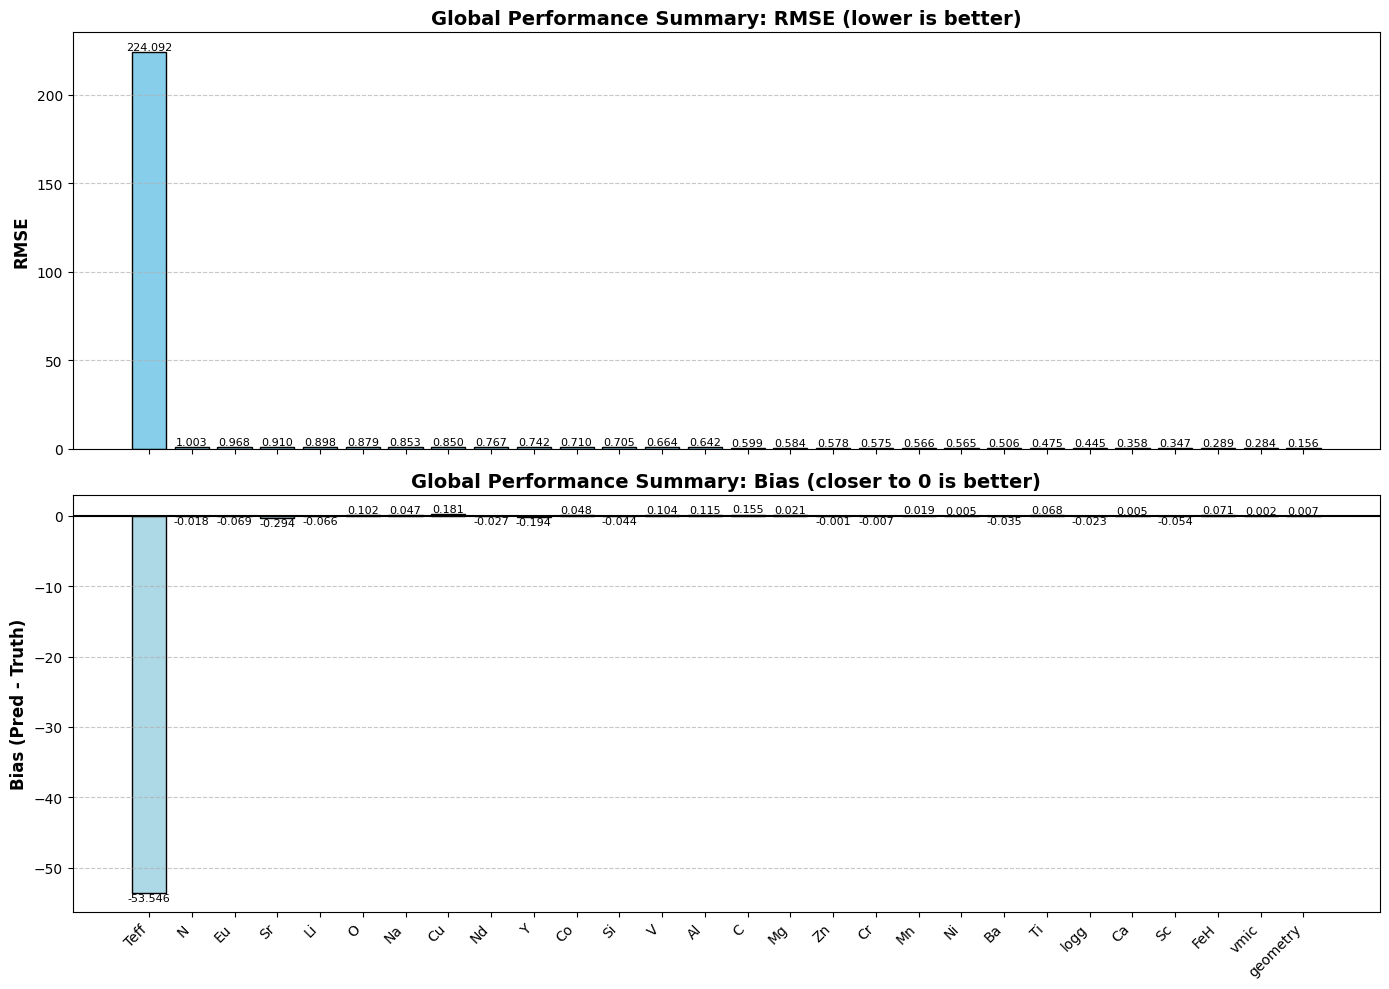

In [9]:
# Cell: Global Summary Plot (RMSE and Bias for all parameters)
def plot_global_summary(metrics_df):
    """
    Plot RMSE and Bias for all parameters in a single summary figure.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # Sort by RMSE for better visualization
    df_sorted = metrics_df.sort_values('RMSE', ascending=False)
    
    # RMSE Plot
    bars1 = ax1.bar(df_sorted['Parameter'], df_sorted['RMSE'], color='skyblue', edgecolor='black')
    ax1.set_ylabel('RMSE', fontsize=12, weight='bold')
    ax1.set_title('Global Performance Summary: RMSE (lower is better)', fontsize=14, weight='bold')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add values on top of bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8, rotation=0)

    # Bias Plot
    colors = ['salmon' if x > 0 else 'lightblue' for x in df_sorted['Bias']]
    bars2 = ax2.bar(df_sorted['Parameter'], df_sorted['Bias'], color=colors, edgecolor='black')
    ax2.set_ylabel('Bias (Pred - Truth)', fontsize=12, weight='bold')
    ax2.set_title('Global Performance Summary: Bias (closer to 0 is better)', fontsize=14, weight='bold')
    ax2.axhline(0, color='black', linewidth=1.5, linestyle='-')
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add values on top/bottom of bars
    for bar in bars2:
        height = bar.get_height()
        va = 'bottom' if height > 0 else 'top'
        offset = 0.01 if height > 0 else -0.01
        ax2.text(bar.get_x() + bar.get_width()/2., height + offset,
                f'{height:.3f}', ha='center', va=va, fontsize=8, rotation=0)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

if 'metrics_df' in globals():
    plot_global_summary(metrics_df)
else:
    # Calculate it if not already done
    if 'test_preds' in globals():
        metrics_df = calculate_global_metrics(globals()['test_preds'], globals()['test_truths'], target_cols)
        plot_global_summary(metrics_df)


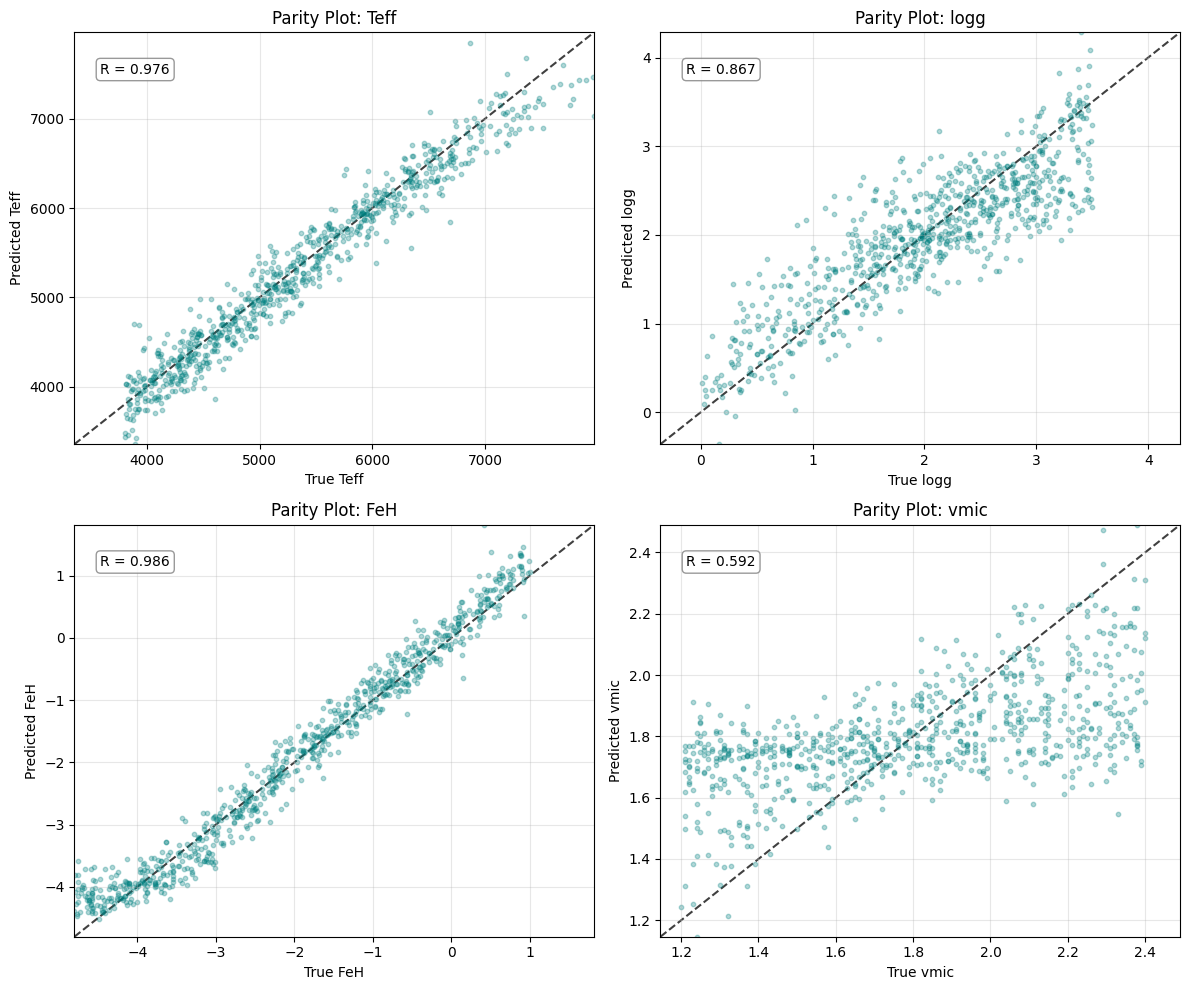

In [10]:
# Cell: Parity Plots (Truth vs Predicted)
def plot_parity_grid(preds, truths, target_cols, keys_to_plot=['Teff', 'logg', 'FeH', 'vmic']):
    """
    Plot a grid of parity plots (Truth vs Predicted) for selected parameters.
    """
    
    # Helper to find index (case-insensitive)
    def find_col_idx(name):
        for i, col in enumerate(target_cols):
            if str(col).lower() == str(name).lower():
                return i
        return None

    n_params = len(keys_to_plot)
    cols = 2
    rows = (n_params + 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))
    axes = axes.flatten()
    
    for i, key in enumerate(keys_to_plot):
        idx = find_col_idx(key)
        if idx is None:
            print(f"Warning: Parameter '{key}' not found in targets. Skipping.")
            continue
            
        ax = axes[i]
        t = truths[:, idx]
        p = preds[:, idx]
        
        # Scatter plot
        ax.scatter(t, p, alpha=0.3, s=10, color='teal')
        
        # 1:1 line
        # Handle cases with no data or nan
        if len(t) > 0 and not np.all(np.isnan(t)): 
            min_val = min(np.nanmin(t), np.nanmin(p))
            max_val = max(np.nanmax(t), np.nanmax(p))
            lims = [min_val, max_val]
            ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
            
            ax.set_xlim(lims)
            ax.set_ylim(lims)
        
        ax.set_xlabel(f'True {key}')
        ax.set_ylabel(f'Predicted {key}')
        ax.set_title(f'Parity Plot: {key}')
        ax.grid(True, alpha=0.3)
        
        # Add correlation coefficient
        if len(t) > 1:
            # Drop NaNs for correlation
            mask = ~np.isnan(t) & ~np.isnan(p)
            if np.sum(mask) > 1:
                corr = np.corrcoef(t[mask], p[mask])[0, 1]
                ax.annotate(f'R = {corr:.3f}', (0.05, 0.9), xycoords='axes fraction', 
                            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.show()

if 'test_preds' in globals():
    target_cols = globals().get('target_cols', [])
    plot_parity_grid(globals()['test_preds'], globals()['test_truths'], target_cols)

### Reliability plot

In [11]:
def plot_reliability_metrics_boxplots(preds,
                                           truths,
                                           param_key=None,
                                           param_name=None,
                                           n_bins=10,
                                           bin_method='quantile',
                                           min_count=5,
                                           figsize=(14, 10),
                                           box_width=0.8,
                                           savename=None):
    """
    Create 3x2 panels of boxplots for the per-bin metric contributions.
    
    Args:
        param_key: name of the parameter (e.g. 'Teff') or integer index. 
                   If name, it's looked up in globals()['label_key_to_idx']
        param_name: Display name for the plot. If None, uses param_key.
    """
    preds = np.asarray(preds); truths = np.asarray(truths)
    assert preds.shape == truths.shape, "preds and truths must have same shape"

    # Resolve index from key
    idx = None
    if isinstance(param_key, int):
        idx = param_key
    elif isinstance(param_key, str):
        # Look up in global mapping
        mapping = globals().get('label_key_to_idx', {})
        # Try direct lookup, then lowercase
        idx = mapping.get(param_key)
        if idx is None:
             idx = mapping.get(param_key.lower())
    
    if idx is None:
        if param_key is None:
            idx = 0 # Default to first
        else:
            print(f"Error: Could not resolve parameter '{param_key}' to an index.")
            print(f"Available keys in mapping: {list(globals().get('label_key_to_idx', {}).keys())}")
            return

    if param_name is None:
        param_name = str(param_key) if param_key is not None else f'Param {idx}'

    tgt = truths[:, idx]
    resid = preds[:, idx] - tgt
    abs_resid = np.abs(resid)
    sq_err = resid ** 2

    unique_vals = np.unique(tgt)
    if unique_vals.size <= n_bins:
        use_unique = True
        edges = None
        centers_to_iter = unique_vals
    else:
        use_unique = False
        if bin_method == 'quantile':
            quantiles = np.linspace(0.0, 1.0, n_bins + 1)
            edges = np.unique(np.quantile(tgt, quantiles))
            if edges.size <= 2:
                edges = np.linspace(tgt.min(), tgt.max(), n_bins + 1)
        else:
            edges = np.linspace(tgt.min(), tgt.max(), n_bins + 1)

    bin_centers_list = []
    resid_groups = []
    sqerr_groups = []
    abs_groups = []
    dev_mean_groups = []
    dev_median_groups = []
    metrics_rows = []

    if use_unique:
        for val in centers_to_iter:
            sel = np.where(tgt == val)[0]
            count = sel.size
            if count < min_count:
                continue
            r = resid[sel]; a = abs_resid[sel]; s = sq_err[sel]
            center = val
            med = np.median(r); mn = np.mean(r)
            rmse = np.sqrt(np.mean(s))
            mae = np.mean(a)
            std_ = np.std(r)
            mad = stats.median_abs_deviation(r, scale='normal')
            bias = np.mean(r)
            var_truth = np.var(tgt[sel])
            r2 = 1.0 - (np.var(r) / var_truth) if var_truth > 0 else np.nan

            bin_centers_list.append(center)
            resid_groups.append(r)
            sqerr_groups.append(s)
            abs_groups.append(a)
            dev_mean_groups.append(np.abs(r - mn))
            dev_median_groups.append(np.abs(r - med))

            metrics_rows.append({'bin_center': center, 'count': count,
                                 'RMSE': rmse, 'MAE': mae, 'STD': std_, 'MAD': mad, 'Bias': bias, 'R2': r2})
    else:
        for i in range(len(edges) - 1):
            left, right = edges[i], edges[i+1]
            if i == len(edges) - 2:
                sel = np.where((tgt >= left) & (tgt <= right))[0]
            else:
                sel = np.where((tgt >= left) & (tgt < right))[0]
            count = sel.size
            if count < min_count:
                continue
            r = resid[sel]; a = abs_resid[sel]; s = sq_err[sel]
            center = (left + right) / 2.0
            med = np.median(r); mn = np.mean(r)
            rmse = np.sqrt(np.mean(s))
            mae = np.mean(a)
            std_ = np.std(r)
            mad = stats.median_abs_deviation(r, scale='normal')
            bias = np.mean(r)
            var_truth = np.var(tgt[sel])
            if var_truth > 0:
                r2 = 1.0 - (np.var(r) / var_truth)
            else:
                r2 = np.nan

            bin_centers_list.append(center)
            resid_groups.append(r)
            sqerr_groups.append(s)
            abs_groups.append(a)
            dev_mean_groups.append(np.abs(r - mn))
            dev_median_groups.append(np.abs(r - med))

            metrics_rows.append({'bin_left': left, 'bin_right': right, 'bin_center': center, 'count': count,
                                 'RMSE': rmse, 'MAE': mae, 'STD': std_, 'MAD': mad, 'Bias': bias, 'R2': r2})

    if len(resid_groups) == 0:
        print("Warning: No bins with >= min_count samples found.")
        return

    df = pd.DataFrame(metrics_rows).sort_values('bin_center').reset_index(drop=True)

    # For RMSE we already computed a per-bin scalar in `metrics_rows` (key 'RMSE').
    # Plot RMSE as a per-bin scalar (sqrt of mean squared error) so units match the parameter.
    metrics = [
        ('RMSE (scalar)', None),
        ('MAE (abs error)', abs_groups),
        ('STD (abs dev from mean)', dev_mean_groups),
        ('MAD (abs dev from median)', dev_median_groups),
        ('Bias (residuals)', resid_groups),
        ('R² (scalar)', None),
    ]

    x = df['bin_center'].values
    # compute width scale for box widths
    width_scale = (x.max() - x.min()) / max(len(x), 1) if len(x) > 1 else 1.0

    fig, axs = plt.subplots(3, 2, figsize=figsize, sharex=True)
    axs = axs.flatten()

    for ax, (title, groups) in zip(axs, metrics):
        if groups is None:
            # Decide which scalar to plot: RMSE or R2
            if 'RMSE' in title:
                y = df['RMSE'].values
                ax.bar(x, y, width=(np.diff(x).min() if len(x) > 1 else 0.5) * 0.6,
                       color='#6baed6', edgecolor='black')
                ax.set_title('RMSE')
                ax.grid(alpha=0.25)
                for xi, yi in zip(x, y):
                    ax.text(xi, yi, f'{yi:.3g}', fontsize=7, ha='left', va='bottom')
            else:
                # R2: plot bar of R2 values
                y = df['R2'].values
                ax.bar(x, y, width=(np.diff(x).min() if len(x) > 1 else 0.5) * 0.6,
                       color='#fdae6b', edgecolor='black')
                ax.set_title('R²')
                ax.grid(alpha=0.25)
                for xi, yi in zip(x, y):
                    ax.text(xi, yi, f'{yi:.3g}', fontsize=7, ha='left', va='bottom')
        else:
            # ensure non-empty arrays for boxplot
            cleaned = [g if (g is not None and g.size > 0) else np.array([np.nan]) for g in groups]
            bp = ax.boxplot(cleaned, positions=x, widths=box_width * width_scale * 0.5,
                            patch_artist=True, manage_ticks=False, showfliers=True)
            for patch in bp['boxes']:
                patch.set_facecolor('#74c476'); patch.set_edgecolor('black'); patch.set_alpha(0.9)
            for median in bp['medians']:
                median.set(color='k', linewidth=1.0)
            ax.set_title(title)
            ax.grid(alpha=0.25)

        ax.set_xlim(x.min() - 0.5 * width_scale, x.max() + 0.5 * width_scale)

    # shared x label on bottom-right subplot
    axs[-1].set_xlabel(param_name)
    plt.suptitle(f'Reliability (metric boxplots) — {param_name}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if savename is not None:
        fig.savefig(savename, dpi=150, bbox_inches='tight')
        print(f'Saved figure to {savename}')

    plt.show()
    return

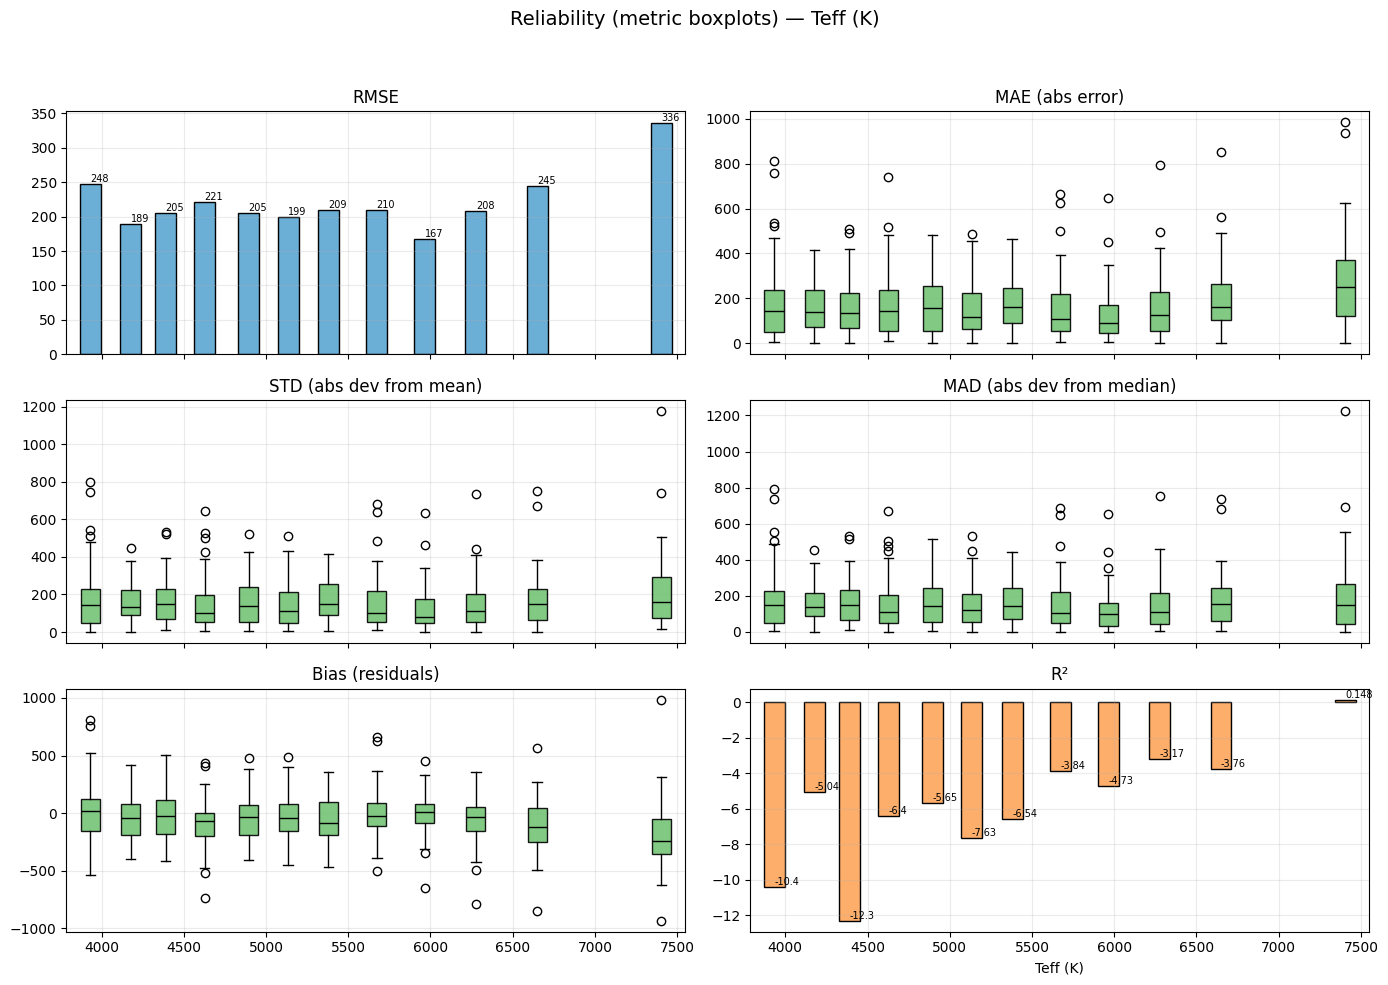

In [12]:
if 'test_preds' in globals():
    plot_reliability_metrics_boxplots(globals()['test_preds'], globals()['test_truths'],
                                           param_key='Teff',
                                           param_name='Teff (K)',
                                           n_bins=12,
                                           bin_method='quantile',
                                           min_count=5)
else:
    print("Predictions not loaded.")

### Analysing Gradients

In [13]:
def analyze_gradient_history(filepath):
    """
    Analyze gradient norms from a training history file.
    
    Parameters
    ----------
    filepath : str
        Path to the file being analyzed.
    """
    data = np.load(filepath)
    # Check if gradient data exists
    if 'grad_norm_mean' not in data:
        print(f"No gradient data found in the provided data")
        return
    
    grad_mean = data['grad_norm_mean']
    grad_max = data['grad_norm_max'] 
    grad_min = data['grad_norm_min']
    train_loss = data.get('train_loss', None)
        
    epochs = len(grad_mean)
        
    print(f"\n{'-'*60}")
    print(f"Gradient Analysis: {filepath}")
    print(f"{'-'*60}")
    print(f"Training epochs: {epochs}")
    print(f"Gradient norm statistics:")
    print(f"  Mean gradient norm: {np.mean(grad_mean):.6f} ± {np.std(grad_mean):.6f}")
    print(f"  Max gradient norm:  {np.max(grad_max):.6f}")
    print(f"  Min gradient norm:  {np.min(grad_min):.6f}")
        
    # Flag potential issues
    exploding_threshold = 10.0
    vanishing_threshold = 1e-6
        
    exploding_epochs = np.where(grad_max > exploding_threshold)[0]
    vanishing_epochs = np.where(grad_min < vanishing_threshold)[0]
        
    if len(exploding_epochs) > 0:
        print(f"  ⚠️  WARNING: Potential exploding gradients detected in {len(exploding_epochs)} epochs")
        print(f"      Affected epochs: {exploding_epochs[:10]}")  # Show first 10
        if len(exploding_epochs) > 10:
            print(f"      ... and {len(exploding_epochs) - 10} more")
        
    if len(vanishing_epochs) > 0:
        print(f"  ⚠️  WARNING: Potential vanishing gradients detected in {len(vanishing_epochs)} epochs")
        print(f"      Affected epochs: {vanishing_epochs[:10]}")  # Show first 10
        if len(vanishing_epochs) > 10:
            print(f"      ... and {len(vanishing_epochs) - 10} more")
        
    # Check for gradient norm trends
    if len(grad_mean) > 10:
        early_mean = np.mean(grad_mean[:len(grad_mean)//3])
        late_mean = np.mean(grad_mean[2*len(grad_mean)//3:])
            
        if late_mean / early_mean < 0.1:
            print(f"  ⚠️  WARNING: Gradient norms decreased significantly during training")
            print(f"      Early mean: {early_mean:.6f}, Late mean: {late_mean:.6f}")
        elif late_mean / early_mean > 10.0:
            print(f"  ⚠️  WARNING: Gradient norms increased significantly during training")
            print(f"      Early mean: {early_mean:.6f}, Late mean: {late_mean:.6f}")
        
    # Assessment
    mean_grad_norm = np.mean(grad_mean)
    if mean_grad_norm > 1.0:
        print(f"  📊 ASSESSMENT: Normal to large gradient norms (good for learning)")
    elif mean_grad_norm > 0.01:
        print(f"  📊 ASSESSMENT: Moderate gradient norms (acceptable)")
    elif mean_grad_norm > 1e-4:
        print(f"  📊 ASSESSMENT: Small gradient norms (may indicate slow learning)")
    else:
        print(f"  📊 ASSESSMENT: Very small gradient norms (potential vanishing gradient issue)")
        
    return grad_mean, grad_max, grad_min, train_loss

In [14]:
def plot_gradient_analysis(filepath: str):
    """
    Plot gradient analysis for a training history file.

    Parameters
    ----------
    filepath : str
        Path to the history file being analyzed.
    """
    # Load data
    grad_mean, grad_max, grad_min, train_loss = analyze_gradient_history(filepath)
    epochs = np.arange(1, len(grad_mean) + 1)

    # Create figure and axes
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Gradient Norm Analysis', fontsize=16, weight='bold')

    # ---- (1) Gradient norms over time ----
    axes[0, 0].plot(epochs, grad_mean, label='Mean', linewidth=2)
    axes[0, 0].plot(epochs, grad_max, '--', alpha=0.7, label='Max')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Gradient Norm')
    axes[0, 0].set_title('Gradient Norms Over Time')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # ---- (2) Gradient scale ratio (max/min) ----
    grad_ratio = np.array(grad_max) / np.maximum(grad_min, 1e-8)
    axes[0, 1].plot(epochs, grad_ratio, color='orange', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Max / Min Gradient Norm')
    axes[0, 1].set_title('Gradient Scale Ratio Over Time')
    axes[0, 1].grid(True, alpha=0.3)

    # ---- (3) Distribution of gradient norms ----
    axes[1, 0].hist(grad_mean, bins=20, color='slateblue', alpha=0.7)
    axes[1, 0].set_xlabel('Mean Gradient Norm')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Gradient Norms')
    axes[1, 0].grid(True, alpha=0.3)

    # ---- (4) Gradient norm vs training loss ----
    axes[1, 1].scatter(grad_mean, train_loss, alpha=0.7, color='teal')
    axes[1, 1].set_xlabel('Mean Gradient Norm')
    axes[1, 1].set_ylabel('Training Loss')
    axes[1, 1].set_title('Gradient Norm vs Training Loss')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return



------------------------------------------------------------
Gradient Analysis: ../ML_models/output/cnn_model_offline.history.npz
------------------------------------------------------------
Training epochs: 50
Gradient norm statistics:
  Mean gradient norm: 1.183529 ± 0.314699
  Max gradient norm:  8.010451
  Min gradient norm:  0.108847
  📊 ASSESSMENT: Normal to large gradient norms (good for learning)


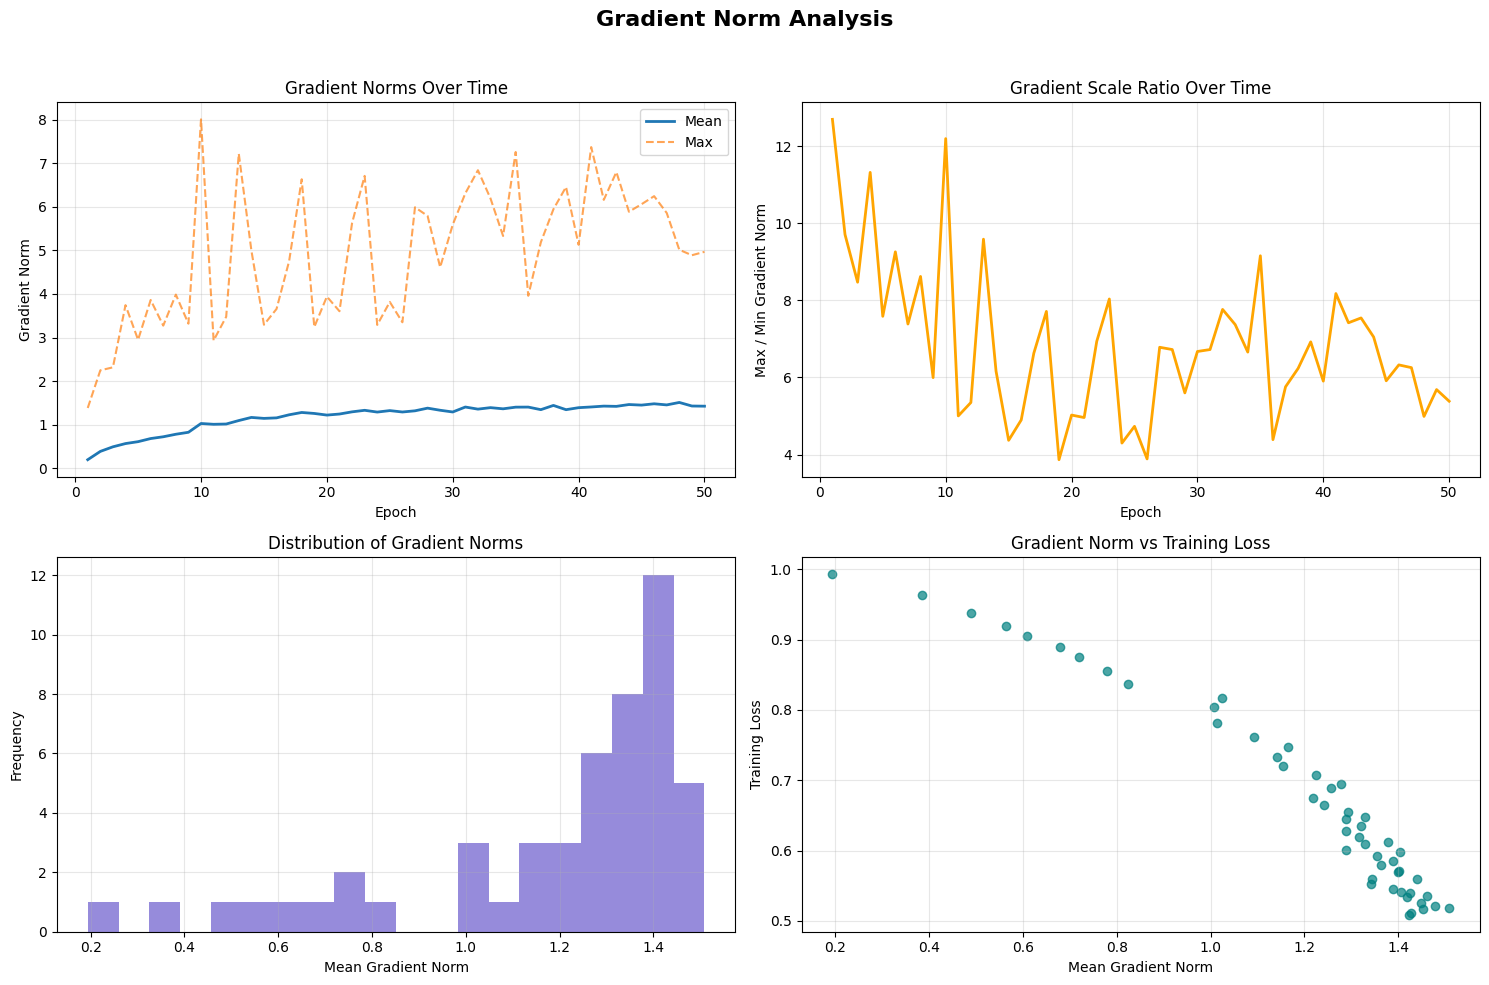

In [15]:
plot_gradient_analysis(HISTORY_PATH)